# Jupyter notebook for Curacel

#Consulting project by Sudip Bhandari (Insight health data science fellow, October 2020). 

Goals: 
#(1) Develop a classification model to identify fraudulent claims. 
#(2) Develop a regression model to adjust costs for claims that need adjustment.

## Table of contents
#A. Data importing and wrangling
#B. Classification models
#C. Cost Adjustment models

## A. Data importing and wrangling

In [1]:
#Import libraries
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix,f1_score,roc_auc_score,roc_curve

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import plot_confusion_matrix

In [2]:
#Import dataset
df = pd.read_csv("ClaimsExcel.csv")

In [3]:
pd.set_option('display.max_columns', 999)

In [4]:
df

,hmo_id,provider_id,care_id,claim_items_amount,amount,id,j,enrollee_id,total_amount,approved_amount,hmo_status,created_at,claim_items_created_at,claim_items_updated_at,hmo_statusnew,claim_items_id,claim_items_claim_id,claim_items_care_id,claim_items_hmo_approved,claim_items_qty,claim_items_approved_amount,claim_items_approved_qty,claim_items_drug_frequency,claim_items_drug_duration,claim_items_drug_duration_sub,claim_items_tariff_id,diagnoses_id,diagnoses_icd_code,_mergeold,_merge
0,1,1,13,5000.0,5000.0,17,1,41565.0,34671.172,31671.170,1.0,2018-03-16T11:02:58.000000Z,2018-03-16T11:02:58.000000Z | 2018-03-16T11:02...,2018-05-21T10:17:04.000000Z | 2018-05-21T10:17...,0.0,66,17,13,1,1,5000.0,1,NaN,NaN,NaN,NaN,16534.0,H26222,matched (3),matched (3)
1,1,1,14,2500.0,2500.0,18,1,101.0,2500.000,2500.000,1.0,2018-03-16T11:05:56.000000Z,2018-03-16T11:05:56.000000Z,2018-05-21T10:17:18.000000Z,0.0,73,18,14,1,1,2500.0,1,NaN,NaN,NaN,NaN,2090.0,NaN,matched (3),matched (3)
2,1,1,177,2500.0,2500.0,31,10,41620.0,99071.172,98171.172,1.0,2018-03-22T14:41:38.000000Z,2018-03-22T14:41:38.000000Z | 2018-03-22T14:41...,2018-07-23T14:03:08.000000Z | 2020-04-30T01:48...,0.0,116,31,177,1,1,2500.0,1,NaN,NaN,NaN,NaN,NaN,NaN,matched (3),matched (3)
3,1,1,220,300.0,300.0,31,12,41620.0,99071.172,98171.172,1.0,2018-03-22T14:41:38.000000Z,2018-03-22T14:41:38.000000Z | 2018-03-22T14:41...,2018-07-23T14:03:08.000000Z | 2020-04-30T01:48...,0.0,118,31,220,1,1,0.0,1,NaN,NaN,NaN,NaN,NaN,NaN,matched (3),matched (3)
4,1,1,274,1500.0,1500.0,31,11,41620.0,99071.172,98171.172,1.0,2018-03-22T14:41:38.000000Z,2018-03-22T14:41:38.000000Z | 2018-03-22T14:41...,2018-07-23T14:03:08.000000Z | 2020-04-30T01:48...,0.0,117,31,274,1,1,1500.0,1,NaN,NaN,NaN,NaN,NaN,NaN,matched (3),matched (3)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
330188,5,475,75952,1200.0,NaN,71003,3,151876.0,7060.000,2480.000,1.0,2020-03-16T10:33:31.000000Z,2020-03-16T10:33:31.000000Z | 2020-03-16T10:33...,2020-05-16T18:28:03.000000Z | 2020-05-16T18:28...,0.0,465672,71003,75952,1,1,800.0,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,using only (2)
330189,5,475,116309,240.0,NaN,70995,2,144310.0,5040.000,2195.000,1.0,2020-03-16T09:34:41.000000Z,2020-03-16T09:34:41.000000Z | 2020-03-16T09:34...,2020-05-26T22:47:05.000000Z | 2020-05-26T22:47...,0.0,465628,70995,116309,1,12,120.0,12,NaN,NaN,NaN,NaN,NaN,NaN,NaN,using only (2)
330190,5,475,116309,240.0,NaN,71233,2,148972.0,4440.000,2420.000,1.0,2020-03-25T13:25:40.000000Z,2020-03-25T13:25:40.000000Z | 2020-03-25T13:25...,2020-05-16T18:28:46.000000Z | 2020-05-16T18:28...,0.0,466968,71233,116309,1,12,120.0,12,NaN,NaN,NaN,NaN,NaN,NaN,NaN,using only (2)
330191,5,475,116309,240.0,NaN,71034,2,150375.0,4440.000,2420.000,1.0,2020-03-16T12:20:14.000000Z,2020-03-16T12:20:14.000000Z | 2020-03-16T12:20...,2020-03-26T09:22:23.000000Z | 2020-03-26T09:22...,0.0,465827,71034,116309,1,12,120.0,12,NaN,NaN,NaN,NaN,NaN,NaN,NaN,using only (2)


In [5]:
#Check summary statistics of the claim amount and approved amount for individual claims
df.agg({'claim_items_amount': ['min', 'max', 'median', 'skew'],
         'claim_items_approved_amount': ['min', 'max', 'median', 'skew']})

,claim_items_amount,claim_items_approved_amount
min,-4.800000e+04,-1.747500e+04
max,2.850000e+06,2.850000e+06
median,1.500000e+03,1.500000e+03
skew,6.050228e+01,7.522056e+01


In [6]:
#Change the negative claim amount to 0
df["claim_items_amount"][df["claim_items_amount"] < 0] = 0
df["claim_items_approved_amount"][df["claim_items_approved_amount"] < 0] = 0

/Users/sudipbhandari/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/Users/sudipbhandari/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [7]:
#Change Nigerian naira to US dollars
df['claim_items_amountusd'] = df['claim_items_amount']/386
df['claim_items_approved_amountusd'] = df['claim_items_approved_amount']/386

In [8]:
#Check summary statistics of the claim amount and approved amount
df.agg({'claim_items_amountusd': ['min', 'max', 'median', 'skew'],
         'claim_items_approved_amountusd': ['min', 'max', 'median', 'skew']})

,claim_items_amountusd,claim_items_approved_amountusd
min,0.000000,0.000000
max,7383.419689,7383.419689
median,3.886010,3.886010
skew,60.506114,75.221287


In [9]:
#Check summary statistics of the total claimed amount and total approved amount
df.agg({'total_amount': ['min', 'max', 'median', 'skew'],
         'approved_amount': ['min', 'max', 'median', 'skew']})

,total_amount,approved_amount
min,-4.501800e+04,0.000000e+00
max,4.104795e+06,4.004595e+06
median,1.645000e+04,1.542600e+04
skew,1.472018e+01,1.541935e+01


In [10]:
#Change the negative claim amount to 0
df["total_amount"][df["total_amount"] < 0] = 0

/Users/sudipbhandari/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [11]:
#Change Nigerian naira to US dollars
df['total_amountusd'] = df['total_amount']/386
df['approved_amountusd'] = df['approved_amount']/386

In [12]:
#Check summary statistics of the total claimed amount and total approved amount for verification
df.agg({'total_amountusd': ['min', 'max', 'median', 'skew'],
         'approved_amountusd': ['min', 'max', 'median', 'skew']})

,total_amountusd,approved_amountusd
min,0.000000,0.000000
max,10634.183938,10374.598446
median,42.616580,39.963731
skew,14.720339,15.419354


In [13]:
#Check value counts for the binary variable claim_items_hmo_approved
df["claim_items_hmo_approved"].value_counts()

 1    315807
-1     14322
 0        64
Name: claim_items_hmo_approved, dtype: int64

In [15]:
#Remove rows for claims that are not approved (1) or disapproved (-1)
df.drop(df.loc[df['claim_items_hmo_approved']==0].index, inplace=True)

### Deal with the missing values.

In [16]:
#Identify features with missing values.
df.isna().sum()

hmo_id                                 0
provider_id                            0
care_id                                0
claim_items_amount                     0
amount                            289261
id                                     0
j                                      0
enrollee_id                           15
total_amount                          25
approved_amount                        0
hmo_status                            33
created_at                             0
claim_items_created_at                 0
claim_items_updated_at                 0
hmo_statusnew                         33
claim_items_id                         0
claim_items_claim_id                   0
claim_items_care_id                    0
claim_items_hmo_approved               0
claim_items_qty                        0
claim_items_approved_amount            0
claim_items_approved_qty               0
claim_items_drug_frequency        324240
claim_items_drug_duration         324309
claim_items_drug

In [17]:
#Fill missing values of total amount usd with median for that variable
df["total_amountusd"].fillna(df["total_amountusd"].median(), inplace = True)

In [18]:
#checking to see what's different
df.agg({'total_amountusd': ['min', 'max', 'median', 'skew'],
         'approved_amountusd': ['min', 'max', 'median', 'skew']})

,total_amountusd,approved_amountusd
min,0.000000,0.000000
max,10634.183938,10374.598446
median,42.616580,39.963731
skew,14.730685,15.426791


In [19]:
#fill missing values with median for total_amountusd
df["total_amount"].fillna(df["total_amount"].median(), inplace = True)

In [20]:
#See if the imputation worked
df["total_amountusd"].isna().sum()

0

In [21]:
#Check whether there are missing values in approved_amount
df["approved_amountusd"].isna().sum()

0

In [22]:
#Check summary statistics of the total claimed amount and total approved amount for verification
df.agg({'total_amountusd': ['min', 'max', 'median', 'skew'],
         'approved_amountusd': ['min', 'max', 'median', 'skew']})

,total_amountusd,approved_amountusd
min,0.000000,0.000000
max,10634.183938,10374.598446
median,42.616580,39.963731
skew,14.730685,15.426791


In [23]:
#Droopping any enrollee id that is missing
df.dropna(subset=['enrollee_id'], inplace = True)

### Univariate and bivariate graphs

Text(0, 0.5, 'Count')

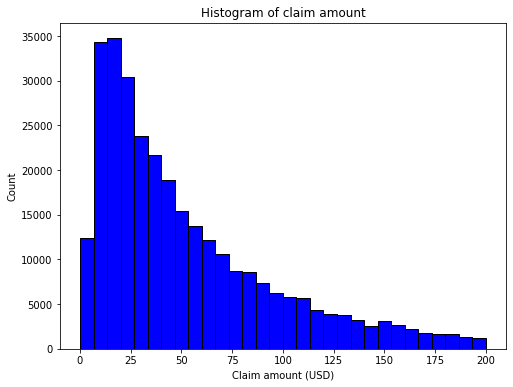

In [24]:
#Graph of total amount claimed
plt.figure(figsize=(8,6))
plt.hist(df['total_amountusd'], color = 'blue', edgecolor = 'black',
         bins = 30, range = (0,200))
plt.title('Histogram of claim amount')
plt.xlabel("Claim amount (USD)")
plt.ylabel("Count")

Text(0, 0.5, 'Count')

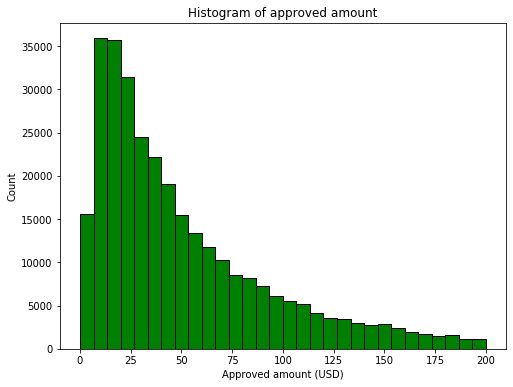

In [26]:
#Graph of approved amount
plt.figure(figsize=(8,6))
plt.hist(df['approved_amountusd'], color = 'green', edgecolor = 'black',
         bins = 30, range = (0,200))
plt.title('Histogram of approved amount')
plt.xlabel("Approved amount (USD)")
plt.ylabel("Count")

No handles with labels found to put in legend.


Text(0, 0.5, 'Count')

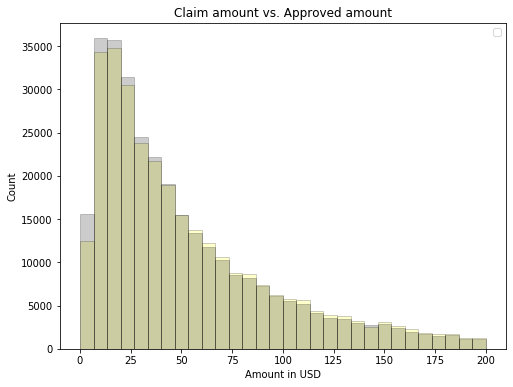

In [27]:
#Graph of claimed amount vs approved amount
plt.figure(figsize=(8,6))
plt.hist(df['total_amountusd'], color = 'yellow', edgecolor = 'black', alpha=0.2, 
         bins = 30, range = (0,200))
plt.hist(df['approved_amountusd'], color = 'black', edgecolor = 'black', alpha=0.2, 
         bins = 30, range = (0,200))
plt.title('Claim amount vs. Approved amount')
plt.legend(loc='upper right')
plt.xlabel("Amount in USD")
plt.ylabel("Count")

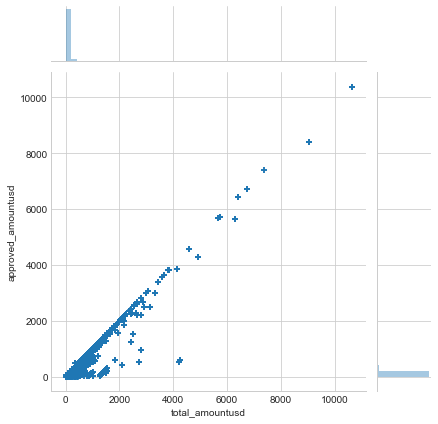

In [28]:
#Jointplot of claimed amount vs. approved amount
plt.style.use('seaborn-whitegrid')
sns.jointplot(x='total_amountusd',y='approved_amountusd', marker = "+", data=df)

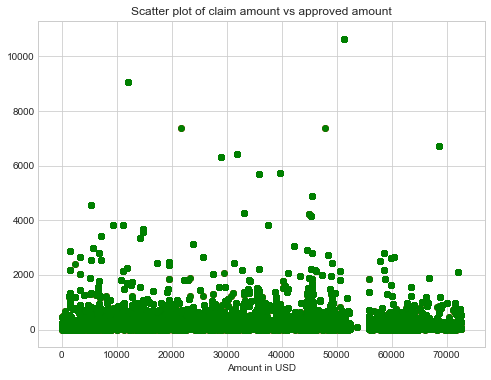

In [29]:
#Scatterplot of claim amount vs. approved amount
plt.figure(figsize=(8,6))
x = df["id"]
y1 = df["total_amountusd"]
y2 = df["approved_amountusd"]
plt.scatter(x, y1, color = "red")
plt.scatter(x, y1, color = "green")

#Labeling 
plt.title('Scatter plot of claim amount vs approved amount')
plt.xlabel('Claim id number')
plt.xlabel('Amount in USD')
plt.show()

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7fec1a440ed0>,
      dtype=object)

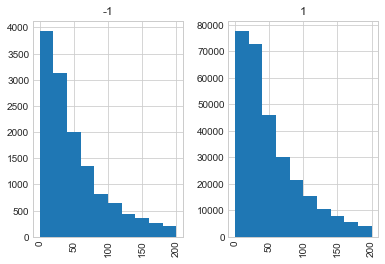

In [30]:
#Evaluating total amount USD based on HMO status
df['total_amountusd'].hist(by=df["claim_items_hmo_approved"], range = (0,200))

### One hot encoding values

In [31]:
df['claim_items_hmo_approved'].value_counts()

 1    315792
-1     14322
Name: claim_items_hmo_approved, dtype: int64

In [32]:
#One hot encoding for the claim_items_hmo_approved
df=pd.get_dummies(df, columns = ["claim_items_hmo_approved"])

In [33]:
#Checking the coding of the claim_items_hmo_approved feature
print(df['claim_items_hmo_approved_-1'].value_counts())

0    315792
1     14322
Name: claim_items_hmo_approved_-1, dtype: int64


In [34]:
#One hot encoding for the hmo_status
df= pd.get_dummies(df, columns = ["hmo_status"])

In [35]:
print(df['hmo_status_-1.0'].value_counts())

0    327434
1      2680
Name: hmo_status_-1.0, dtype: int64


In [36]:
#Check whether the variables are included in the dataframe 
df

,hmo_id,provider_id,care_id,claim_items_amount,amount,id,j,enrollee_id,total_amount,approved_amount,created_at,claim_items_created_at,claim_items_updated_at,hmo_statusnew,claim_items_id,claim_items_claim_id,claim_items_care_id,claim_items_qty,claim_items_approved_amount,claim_items_approved_qty,claim_items_drug_frequency,claim_items_drug_duration,claim_items_drug_duration_sub,claim_items_tariff_id,diagnoses_id,diagnoses_icd_code,_mergeold,_merge,claim_items_amountusd,claim_items_approved_amountusd,total_amountusd,approved_amountusd,claim_items_hmo_approved_-1,claim_items_hmo_approved_1,hmo_status_-1.0,hmo_status_1.0
0,1,1,13,5000.0,5000.0,17,1,41565.0,34671.172,31671.170,2018-03-16T11:02:58.000000Z,2018-03-16T11:02:58.000000Z | 2018-03-16T11:02...,2018-05-21T10:17:04.000000Z | 2018-05-21T10:17...,0.0,66,17,13,1,5000.0,1,NaN,NaN,NaN,NaN,16534.0,H26222,matched (3),matched (3),12.953368,12.953368,89.821689,82.049663,0,1,0,1
1,1,1,14,2500.0,2500.0,18,1,101.0,2500.000,2500.000,2018-03-16T11:05:56.000000Z,2018-03-16T11:05:56.000000Z,2018-05-21T10:17:18.000000Z,0.0,73,18,14,1,2500.0,1,NaN,NaN,NaN,NaN,2090.0,NaN,matched (3),matched (3),6.476684,6.476684,6.476684,6.476684,0,1,0,1
2,1,1,177,2500.0,2500.0,31,10,41620.0,99071.172,98171.172,2018-03-22T14:41:38.000000Z,2018-03-22T14:41:38.000000Z | 2018-03-22T14:41...,2018-07-23T14:03:08.000000Z | 2020-04-30T01:48...,0.0,116,31,177,1,2500.0,1,NaN,NaN,NaN,NaN,NaN,NaN,matched (3),matched (3),6.476684,6.476684,256.661067,254.329461,0,1,0,1
3,1,1,220,300.0,300.0,31,12,41620.0,99071.172,98171.172,2018-03-22T14:41:38.000000Z,2018-03-22T14:41:38.000000Z | 2018-03-22T14:41...,2018-07-23T14:03:08.000000Z | 2020-04-30T01:48...,0.0,118,31,220,1,0.0,1,NaN,NaN,NaN,NaN,NaN,NaN,matched (3),matched (3),0.777202,0.000000,256.661067,254.329461,0,1,0,1
4,1,1,274,1500.0,1500.0,31,11,41620.0,99071.172,98171.172,2018-03-22T14:41:38.000000Z,2018-03-22T14:41:38.000000Z | 2018-03-22T14:41...,2018-07-23T14:03:08.000000Z | 2020-04-30T01:48...,0.0,117,31,274,1,1500.0,1,NaN,NaN,NaN,NaN,NaN,NaN,matched (3),matched (3),3.886010,3.886010,256.661067,254.329461,0,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
330188,5,475,75952,1200.0,NaN,71003,3,151876.0,7060.000,2480.000,2020-03-16T10:33:31.000000Z,2020-03-16T10:33:31.000000Z | 2020-03-16T10:33...,2020-05-16T18:28:03.000000Z | 2020-05-16T18:28...,0.0,465672,71003,75952,1,800.0,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,using only (2),3.108808,2.072539,18.290155,6.424870,0,1,0,1
330189,5,475,116309,240.0,NaN,70995,2,144310.0,5040.000,2195.000,2020-03-16T09:34:41.000000Z,2020-03-16T09:34:41.000000Z | 2020-03-16T09:34...,2020-05-26T22:47:05.000000Z | 2020-05-26T22:47...,0.0,465628,70995,116309,12,120.0,12,NaN,NaN,NaN,NaN,NaN,NaN,NaN,using only (2),0.621762,0.310881,13.056995,5.686528,0,1,0,1
330190,5,475,116309,240.0,NaN,71233,2,148972.0,4440.000,2420.000,2020-03-25T13:25:40.000000Z,2020-03-25T13:25:40.000000Z | 2020-03-25T13:25...,2020-05-16T18:28:46.000000Z | 2020-05-16T18:28...,0.0,466968,71233,116309,12,120.0,12,NaN,NaN,NaN,NaN,NaN,NaN,NaN,using only (2),0.621762,0.310881,11.502591,6.269430,0,1,0,1
330191,5,475,116309,240.0,NaN,71034,2,150375.0,4440.000,2420.000,2020-03-16T12:20:14.000000Z,2020-03-16T12:20:14.000000Z | 2020-03-16T12:20...,2020-03-26T09:22:23.000000Z | 2020-03-26T09:22...,0.0,465827,71034,116309,12,120.0,12,NaN,NaN,NaN,NaN,NaN,NaN,NaN,using only (2),0.621762,0.310881,11.502591,6.269430,0,1,0,1


# B. Classification models

## RandomForest

In [60]:
#Double check missing values
df.isna().sum()

hmo_id                                 0
provider_id                            0
care_id                                0
claim_items_amount                     0
amount                            289250
id                                     0
j                                      0
enrollee_id                            0
total_amount                           0
approved_amount                        0
created_at                             0
claim_items_created_at                 0
claim_items_updated_at                 0
hmo_statusnew                         33
claim_items_id                         0
claim_items_claim_id                   0
claim_items_care_id                    0
claim_items_qty                        0
claim_items_approved_amount            0
claim_items_approved_qty               0
claim_items_drug_frequency        324225
claim_items_drug_duration         324294
claim_items_drug_duration_sub     324353
claim_items_tariff_id             330061
diagnoses_id    

In [61]:
rfc = RandomForestClassifier(n_estimators=100, random_state = 42)

In [62]:
X = df[["total_amountusd", "claim_items_amountusd", "claim_items_qty", 
            "claim_items_care_id", 
            "hmo_id", "enrollee_id", "care_id", "claim_items_id",
           "claim_items_claim_id"]]
y = df["hmo_status_-1.0"]

In [63]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [64]:
rfc.fit(X_train,y_train)

RandomForestClassifier(random_state=42)

In [65]:
rfc_predict = rfc.predict(X_test)

In [66]:
confusion_matrix(y_test, rfc_predict)

array([[65442,    10],
       [  217,   354]])

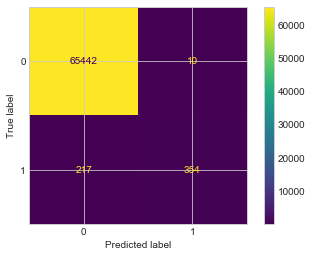

In [67]:
y_pre = rfc.predict(X_test)

cm = confusion_matrix(y_test, y_pre)

cm_display = ConfusionMatrixDisplay(cm).plot()

In [68]:
print(classification_report(y_test,y_pre))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     65452
           1       0.97      0.62      0.76       571

    accuracy                           1.00     66023
   macro avg       0.98      0.81      0.88     66023
weighted avg       1.00      1.00      1.00     66023



In [69]:
importance = rfc.feature_importances_

Feature: 0, Score: 0.15128
Feature: 1, Score: 0.04943
Feature: 2, Score: 0.02636
Feature: 3, Score: 0.07434
Feature: 4, Score: 0.00141
Feature: 5, Score: 0.15492
Feature: 6, Score: 0.07438
Feature: 7, Score: 0.24335
Feature: 8, Score: 0.22454


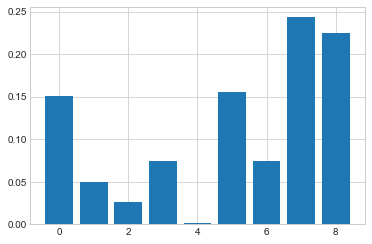

In [70]:
for i,v in enumerate(importance):
    print('Feature: %0d, Score: %.5f' % (i,v))
# plot feature importance
plt.bar([x for x in range(len(importance))], importance)
plt.show()

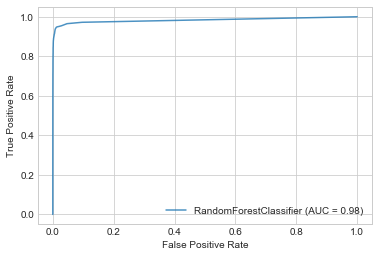

In [71]:
from sklearn.metrics import plot_roc_curve
ax = plt.gca()
rfc_disp = plot_roc_curve(rfc, X_test, y_test, ax=ax, alpha=0.8)
plt.show()

In [72]:
#Run SMOTE to deal with class imbalance
from collections import Counter
from sklearn.datasets import make_classification
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import StratifiedKFold

from sklearn.datasets import make_classification
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import label_binarize

In [73]:
sm = SMOTE(random_state=42)
X_res, y_res = sm.fit_resample(X_train, y_train)

print('Resampled dataset shape %s' % Counter(y_res))

Resampled dataset shape Counter({0: 261982, 1: 261982})


In [74]:
len(y_res[y_res==1])

261982

In [75]:
#random forest after SMOTE
clf=RandomForestClassifier(random_state=0)
clf.fit(X_res,y_res)

RandomForestClassifier(random_state=0)

In [76]:
actual = y_test
predictions=clf.predict(X_test)

In [77]:
confusion_matrix(actual,predictions)

array([[65304,   148],
       [  193,   378]])

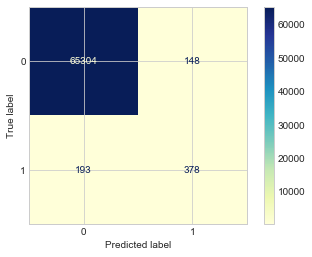

In [78]:
cm = confusion_matrix(actual, predictions)

cm_display = ConfusionMatrixDisplay(cm).plot(cmap= "YlGnBu")

<function matplotlib.pyplot.show(*args, **kw)>

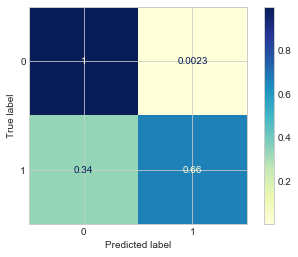

In [79]:
#Normalized confusion matrix
plot_confusion_matrix(clf, X_test, y_test, normalize = 'true', cmap= 'YlGnBu' )
plt.show

In [80]:
from sklearn.metrics import roc_curve, auc

false_positive_rate, true_positive_rate, thresholds = roc_curve(actual, predictions)
roc_auc = auc(false_positive_rate, true_positive_rate)
print (roc_auc)

0.8298676491632


Text(0.5, 0, 'False Positive Rate')

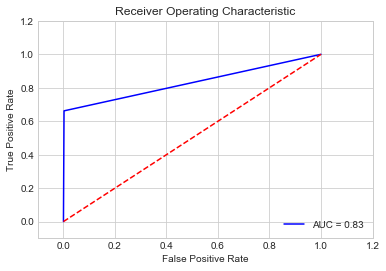

In [81]:
plt.title('Receiver Operating Characteristic')
plt.plot(false_positive_rate, true_positive_rate, 'b', label='AUC = %0.2f'% roc_auc)
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'r--')
plt.xlim([-0.1,1.2])
plt.ylim([-0.1,1.2])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')

# C. Cost-adjustment model

### Prepare dataset for linear regression

In [139]:
#Create a new feature to consider the adjusted amount
df["adjusted_amountusd"] = df["total_amountusd"]- df["approved_amountusd"]

In [140]:
list(df.columns)

['hmo_id',
 'provider_id',
 'care_id',
 'claim_items_amount',
 'amount',
 'id',
 'j',
 'enrollee_id',
 'total_amount',
 'approved_amount',
 'created_at',
 'claim_items_created_at',
 'claim_items_updated_at',
 'hmo_statusnew',
 'claim_items_id',
 'claim_items_claim_id',
 'claim_items_care_id',
 'claim_items_qty',
 'claim_items_approved_amount',
 'claim_items_approved_qty',
 'claim_items_drug_frequency',
 'claim_items_drug_duration',
 'claim_items_drug_duration_sub',
 'claim_items_tariff_id',
 'diagnoses_id',
 'diagnoses_icd_code',
 '_mergeold',
 '_merge',
 'claim_items_amountusd',
 'claim_items_approved_amountusd',
 'total_amountusd',
 'approved_amountusd',
 'claim_items_hmo_approved_-1',
 'claim_items_hmo_approved_1',
 'hmo_status_-1.0',
 'hmo_status_1.0',
 'adjusted_amountusd']

In [141]:
#Create a new dataframe with a few features
dfad = df[['adjusted_amountusd', 'approved_amountusd', 'total_amountusd', 'hmo_id', "provider_id", "care_id",
          "claim_items_amount", "claim_items_care_id", "claim_items_qty", "claim_items_amountusd", "enrollee_id",
            "claim_items_approved_amountusd","claim_items_id", "claim_items_claim_id"]].copy()

In [142]:
#Drop rows with claims that did not go through any adjustment
dfad.drop(dfad.loc[df['adjusted_amountusd']==0].index, inplace=True)

In [143]:
#Drop rows with negative claims adjustment
dfad.drop(dfad.loc[df['adjusted_amountusd']<0].index, inplace=True)

In [144]:
dfad

,adjusted_amountusd,approved_amountusd,total_amountusd,hmo_id,provider_id,care_id,claim_items_amount,claim_items_care_id,claim_items_qty,claim_items_amountusd,enrollee_id,claim_items_approved_amountusd,claim_items_id,claim_items_claim_id
0,7.772026,82.049663,89.821689,1,1,13,5000.0,13,1,12.953368,41565.0,12.953368,66,17
2,2.331606,254.329461,256.661067,1,1,177,2500.0,177,1,6.476684,41620.0,6.476684,116,31
3,2.331606,254.329461,256.661067,1,1,220,300.0,220,1,0.777202,41620.0,0.000000,118,31
4,2.331606,254.329461,256.661067,1,1,274,1500.0,274,1,3.886010,41620.0,3.886010,117,31
9,7.772026,82.049663,89.821689,1,1,1176,14400.0,1176,9,37.305699,41565.0,37.305699,70,17
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
330188,11.865285,6.424870,18.290155,5,475,75952,1200.0,75952,1,3.108808,151876.0,2.072539,465672,71003
330189,7.370466,5.686528,13.056995,5,475,116309,240.0,116309,12,0.621762,144310.0,0.310881,465628,70995
330190,5.233161,6.269430,11.502591,5,475,116309,240.0,116309,12,0.621762,148972.0,0.310881,466968,71233
330191,5.233161,6.269430,11.502591,5,475,116309,240.0,116309,12,0.621762,150375.0,0.310881,465827,71034


In [145]:
dfad.describe()

,adjusted_amountusd,approved_amountusd,total_amountusd,hmo_id,provider_id,care_id,claim_items_amount,claim_items_care_id,claim_items_qty,claim_items_amountusd,enrollee_id,claim_items_approved_amountusd,claim_items_id,claim_items_claim_id
count,76136.000000,76136.000000,76136.000000,76136.000000,76136.000000,76136.000000,7.613600e+04,76136.000000,76136.000000,76136.000000,76136.000000,76136.000000,76136.000000,76136.00000
mean,34.428944,154.382398,188.811342,1.188899,140.766300,24019.098613,4.804380e+03,24019.098613,13.022617,12.446581,96501.291636,8.860751,263942.791137,38216.72335
std,124.435773,574.993869,626.074723,0.664629,107.648083,23390.862072,2.575703e+04,23390.862072,105.786633,66.728053,32007.046587,45.197747,144159.438702,20778.65965
min,0.005181,0.000000,0.259067,1.000000,1.000000,7.000000,0.000000e+00,7.000000,-30.000000,0.000000,2.000000,0.000000,60.000000,15.00000
25%,2.590674,21.373057,29.715026,1.000000,75.000000,5702.000000,6.750000e+02,5702.000000,1.000000,1.748705,85882.000000,0.777202,124416.000000,18976.00000
50%,7.772021,47.810881,63.056995,1.000000,100.000000,18489.000000,1.500000e+03,18489.000000,2.000000,3.886010,108579.000000,2.901554,297376.000000,41967.00000
75%,22.538860,100.712435,124.987513,1.000000,188.000000,36322.750000,4.000000e+03,36322.750000,18.000000,10.362694,113197.000000,7.772021,392009.750000,56946.00000
max,3673.368135,10374.598446,10634.183938,5.000000,478.000000,140097.000000,2.500000e+06,140097.000000,12000.000000,6476.683938,162081.000000,6476.683938,475565.000000,72565.00000


In [146]:
dfad.isna().sum()

adjusted_amountusd                0
approved_amountusd                0
total_amountusd                   0
hmo_id                            0
provider_id                       0
care_id                           0
claim_items_amount                0
claim_items_care_id               0
claim_items_qty                   0
claim_items_amountusd             0
enrollee_id                       0
claim_items_approved_amountusd    0
claim_items_id                    0
claim_items_claim_id              0
dtype: int64

# Regression model

In [245]:
y = dfad['approved_amountusd']

In [246]:
X = dfad[["total_amountusd","hmo_id", "claim_items_amount", "care_id","claim_items_care_id", 
         "claim_items_qty", "claim_items_amountusd", "enrollee_id","claim_items_approved_amountusd", 
         "claim_items_id","claim_items_claim_id"]]

In [247]:
from sklearn.model_selection import train_test_split

In [248]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=101)

In [249]:
from sklearn.linear_model import LinearRegression

In [250]:
lm = LinearRegression()

In [251]:
lm.fit(X_train,y_train)

LinearRegression()

In [252]:
print('Coefficients: \n', lm.coef_)

Coefficients: 
 [ 9.10316520e-01  1.06430099e+01 -2.45653952e-03 -4.20430026e-05
 -4.20431302e-05 -6.37129825e-03 -6.36409185e-06 -1.05021167e-04
  1.02712197e+00 -8.93633271e-05  2.35097248e-04]


In [253]:
predictions = lm.predict( X_test)

Text(0, 0.5, 'Predicted Y')

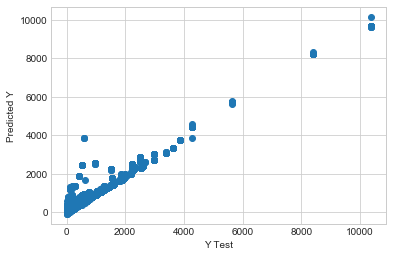

In [254]:
plt.scatter(y_test,predictions)
plt.xlabel('Y Test')
plt.ylabel('Predicted Y')

In [255]:
#Calculate these metrics by hand.
from sklearn import metrics
print('MAE:', metrics.mean_absolute_error(y_test, predictions))
print('MSE:', metrics.mean_squared_error(y_test, predictions))
print('RMSE:', np.sqrt(metrics.mean_squared_error(y_test, predictions)))

MAE: 29.657070245903007
MSE: 10803.572401041296
RMSE: 103.94023475556179


In [256]:
#R-squared value for the regression model
metrics.explained_variance_score(y_test, predictions)

0.9660668383284774

(array([1.800e+01, 1.500e+01, 2.900e+01, 7.200e+01, 1.200e+01, 2.100e+01,
        4.000e+01, 6.000e+00, 1.800e+01, 2.700e+01, 4.200e+01, 2.100e+01,
        3.000e+01, 3.300e+01, 6.900e+01, 7.900e+01, 1.170e+02, 1.050e+02,
        1.140e+02, 2.020e+02, 2.680e+02, 3.740e+02, 5.050e+02, 1.002e+03,
        2.041e+03, 3.941e+03, 5.660e+03, 4.347e+03, 2.188e+03, 3.540e+02,
        1.220e+02, 1.010e+02, 9.600e+01, 3.600e+01, 1.800e+01, 2.500e+01,
        3.100e+01, 2.300e+01, 3.300e+01, 3.000e+01, 1.000e+01, 2.200e+01,
        8.000e+00, 8.000e+00, 2.400e+01, 3.800e+01, 1.300e+01, 1.300e+01,
        4.000e+00, 0.000e+00]),
 array([-200., -192., -184., -176., -168., -160., -152., -144., -136.,
        -128., -120., -112., -104.,  -96.,  -88.,  -80.,  -72.,  -64.,
         -56.,  -48.,  -40.,  -32.,  -24.,  -16.,   -8.,    0.,    8.,
          16.,   24.,   32.,   40.,   48.,   56.,   64.,   72.,   80.,
          88.,   96.,  104.,  112.,  120.,  128.,  136.,  144.,  152.,
         160.,  168.,

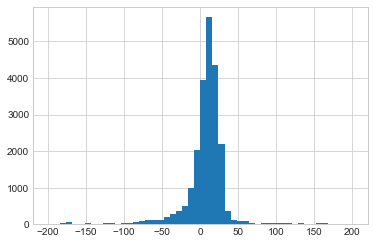

In [257]:
#Predction error plot 
plt.hist((y_test-predictions), bins = 50, range = [-200,200])

In [258]:
coeffecients = pd.DataFrame(lm.coef_,X.columns)
coeffecients.columns = ['Coeffecient']
coeffecients

,Coeffecient
total_amountusd,0.910317
hmo_id,10.643010
claim_items_amount,-0.002457
care_id,-0.000042
claim_items_care_id,-0.000042
claim_items_qty,-0.006371
claim_items_amountusd,-0.000006
enrollee_id,-0.000105
claim_items_approved_amountusd,1.027122
claim_items_id,-0.000089
